<a href="https://colab.research.google.com/github/jdmogollonp/Agiles_Apropiacion/blob/master/Rappi_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Rappi Data Science Challenge



#Objetivo 
Objetivo : 
Identificar las subcategorías que le correspondería a cada producto
en train_challenge, entrenar un clasificador y predecir las subcategorías para
test_challenge.




# Librerias requeridas para el desarrollo de la prueba
Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías


In [1]:
!pip install transformers==3.1.0

     |████████████████████████████████| 890kB 14.0MB/s 
     |████████████████████████████████| 890kB 52.8MB/s 
     |████████████████████████████████| 1.1MB 48.5MB/s 
     |████████████████████████████████| 3.0MB 45.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=5df0aa71c67708e1aad0b77bd3c7f76380e1046322e72ce8b9cfdc1b088ce8b2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from transformers import pipeline
import pandas as pd

import numpy as np
import re, string, unicodedata
from wordcloud import WordCloud
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import inflect

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve, accuracy_score, make_scorer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline, FeatureUnion



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


#  Perfilamiento y entendimiento de los datos


En primer lugar, se realizan algunas tareas de procesamiento de los textos como tokenización, se remueven stopwords, términos no ascii, asi mismo se remueve la puntuación y se pasan a minúscula los tokens. Y en segundo lugar, se presenta un breve análisis exploratorio de los textos en términos de la distribución de frecuencias de palabras que se encuentran en los nombres de los productos. 



In [5]:
data   = pd.read_csv("train_challenge.csv", sep = ',')

In [6]:
# functions to clean texts

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preproccesing(words):
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

In [7]:
data['words'] = data['name'].apply(word_tokenize)
data['words'] = data['words'].apply(preproccesing)
data['words'] = data['words'].apply(lambda x: ' '.join(map(str, x)))
data.head()

,name,description,maker,trademark,words
0,Cerveza Otro Mundo 500 Ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo,cerveza otro mundo 500 ml
1,Vino San Telmo Varietales X750Ml.,Vino San Telmo Varietales X750Ml.,NaN,San Telmo,vino san telmo varietales x750ml
2,Mayonesa Natura 1000cc,Mayonesa Natura con jugo de limon sachet x 100...,gallega,Natura,mayonesa natura 1000cc
3,Brahma Chopp 354cc x 6,Brahma Chopp 354cc x 6,NaN,Brahma,brahma chopp 354cc x 6
4,Mayonesa HellmannS Light Doypack 237 Gr,Mayonesa HellmannS Light Doypack 237 Gr,NaN,Hellmann´S,mayonesa hellmanns light doypack 237 gr


En la siguiente ilustración se presenta la nube de palabras que representa la distribución de frecuencias de los tokens presentando aquellos que aparecen más de 20 veces.

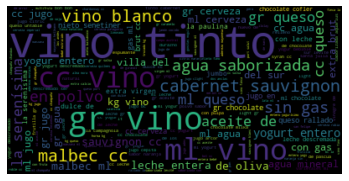

In [8]:
words = data['words']
words = [w for w in words if len(w) > 20]  
words = [w.lower() for w in words]
clean_string = ','.join(words)

text = clean_string
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

De esta nube de palabras queda en evidencia por ejemplo,que el token 'vino' es uno de los tokens más frecuentes en los nombres de los productos.


In [9]:
data['first_words']  = data.words.str.split().str.get(0)
data.head(5)

,name,description,maker,trademark,words,first_words
0,Cerveza Otro Mundo 500 Ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo,cerveza otro mundo 500 ml,cerveza
1,Vino San Telmo Varietales X750Ml.,Vino San Telmo Varietales X750Ml.,NaN,San Telmo,vino san telmo varietales x750ml,vino
2,Mayonesa Natura 1000cc,Mayonesa Natura con jugo de limon sachet x 100...,gallega,Natura,mayonesa natura 1000cc,mayonesa
3,Brahma Chopp 354cc x 6,Brahma Chopp 354cc x 6,NaN,Brahma,brahma chopp 354cc x 6,brahma
4,Mayonesa HellmannS Light Doypack 237 Gr,Mayonesa HellmannS Light Doypack 237 Gr,NaN,Hellmann´S,mayonesa hellmanns light doypack 237 gr,mayonesa


Se considera además los conteos de las palabras que aparecen en la primera posición del nombre del producto. 

In [10]:
first_words  = pd.DataFrame(data.words.str.split().str.get(0))
first_words.sort_values("words", inplace = True) 
first_words.words.value_counts()

vino           2116
queso           958
jugo            672
cerveza         640
agua            554
               ... 
centro            1
mast              1
huevofrozen       1
trozos            1
pomelada          1
Name: words, Length: 322, dtype: int64

Del conteo de las primeras palabras de los nombres de los productos se encontró que hay 322 palabras distintas. En la siguiente gráfica se muestra la frecuencia  de las 30 palabras más comunes. 

Se puede ver que en las 20 palabras más frecuentes se encuentra el 80% de los datos.





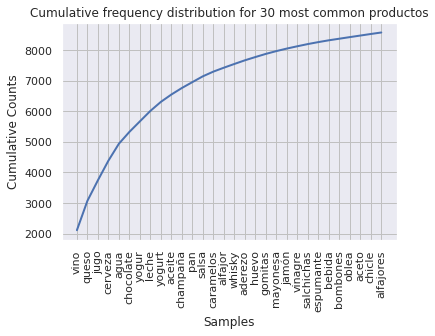

In [11]:
words = [w for w in first_words.words ]
words_freq = FreqDist(words)
words_freq.plot(30,title='Cumulative frequency distribution for 30 most common productos', cumulative=True)



# Identificación de las categorias para el conjunto de entrenamiento





Para la identificación de las categorías se hace uso de la estrategia denominada "Zero-Shot Classification" la cuál está basada en el modelo pre-entrenado disponible en el [sitio web](https://huggingface.co/joeddav/xlm-roberta-large-xnli) de Huggingface. La descripción se encuentra  en el [artículo](https://arxiv.org/abs/1911.02116)  que introduce el modelo XLM Roberta. La implementación en este caso se realiza en español por lo que se considera un modelo cross-lingual, basado en  XLM RoBERTa(`model='joeddav/xlm-roberta-large-xnli').

En cuanto a la implementación, se define un pipeline que hace uso de la lista de categorías predefinidas para los productos. Se asume en este ejercicio que los productos pueden pertenecer a múltiples categorías (multi_class = True). Por lo que los resultados serán independientes y estarán entre cero y uno para cada categoría y para efectos del entrenamiento del clasificador se considera la categoría con el puntaje más alto.

Esta estrategia permite resolver el problema de la clasificación no supervisada de los nombres de los productos ya que no se tienen de antemano las categorías de cada producto y tampoco se tiene suficiente información para entrenar un modelo Guided-Lda.



In [12]:
classifier = pipeline("zero-shot-classification", model='joeddav/xlm-roberta-large-xnli')

In [14]:
def semantic_similarity(sequence):
  candidate_labels = ['Fiambres', 'Panificados', 'Salchichas', 'Aderezos','Aceites y Vinagres', 'Golosinas y Chocolates', 
                'Jugos', 'Aguas', 'Vinos', 'Cervezas', 'Whiskies', 'Champagnes' ,'Quesos', 'Leches', 'Yogures']
  categories = classifier(sequence, candidate_labels,multi_class=True)
  return categories['labels'][0]

El clasificador instanciado considera la lista de las categorias predefinidas y realiza la clasificación semantica  de frases y palabras. En el siguiente ejemplo se muestra el resultado del clasificador para un producto del dataset. 

In [15]:
%%time
semantic_similarity("Cerveza Otro Mundo 500 Ml")

CPU times: user 3.47 s, sys: 16.9 ms, total: 3.49 s
Wall time: 3.66 s


'Cervezas'

El tiempo de procesamiento de la clasificación de un registro utilizando el modelo propuesto esta por encima de 3 segundos para cada registro. Por lo que, evaluar el modelo para los 10 mil registros del conjunto de entrenamiento puede tomar alrededor de 10 horas. 

Como estrategia para determinar las categorías de todos los productos y ahorrar tiempo de procesamiento se evaluará el clasificador únicamente en las 322 palabras diferentes encontradas en la primera posición de los nombres de los productos.




In [16]:
training_df = data.copy()
training_df['key'] = training_df.first_words
training_df.head(5)

,name,description,maker,trademark,words,first_words,key
0,Cerveza Otro Mundo 500 Ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo,cerveza otro mundo 500 ml,cerveza,cerveza
1,Vino San Telmo Varietales X750Ml.,Vino San Telmo Varietales X750Ml.,NaN,San Telmo,vino san telmo varietales x750ml,vino,vino
2,Mayonesa Natura 1000cc,Mayonesa Natura con jugo de limon sachet x 100...,gallega,Natura,mayonesa natura 1000cc,mayonesa,mayonesa
3,Brahma Chopp 354cc x 6,Brahma Chopp 354cc x 6,NaN,Brahma,brahma chopp 354cc x 6,brahma,brahma
4,Mayonesa HellmannS Light Doypack 237 Gr,Mayonesa HellmannS Light Doypack 237 Gr,NaN,Hellmann´S,mayonesa hellmanns light doypack 237 gr,mayonesa,mayonesa


In [17]:
# dropping ALL duplicte values 
first_words.drop_duplicates(subset ="words", 
                     keep = 'first', inplace = True) 
first_words.shape

(322, 1)

In [18]:
%%time
first_words['categoria'] = first_words.apply(lambda x : semantic_similarity(x['words']),axis=1)

CPU times: user 13min 36s, sys: 2.15 s, total: 13min 38s
Wall time: 13min 38s


In [21]:
first_words.rename(columns={"words": "key"}, inplace = True)
first_words.head(5)

,key,categoria
5404,aberlour,Aderezos
8377,aceite,Aceites y Vinagres
2883,aceto,Aceites y Vinagres
9131,aderezo,Aderezos
9657,adobo,Aderezos


In [22]:
training_df= pd.merge(training_df,first_words,how = 'left', on =['key'] )

# Entrenamiento de un clasificador




Para el entrenamiento se utiliza el modelo MLP(Multilayer Perceptron), el cual corresponde a la 
categoría de redes neuronales conocidas como FeedForward Neural Networks. Este tipo de redes Se utilizan en el contexto del aprendizaje supervisado.

In [23]:
training_df.head(1)

,name,description,maker,trademark,words,first_words,key,categoria
0,Cerveza Otro Mundo 500 Ml,Cerveza Otro Mundo 500 Ml,NaN,Otro Mundo,cerveza otro mundo 500 ml,cerveza,cerveza,Cervezas


In [24]:
X, y = training_df['name'],training_df['categoria']
y = pd.get_dummies(y)
y

,Aceites y Vinagres,Aderezos,Aguas,Cervezas,Champagnes,Fiambres,Golosinas y Chocolates,Jugos,Leches,Panificados,Quesos,Salchichas,Vinos,Whiskies,Yogures
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9997,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [25]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X)
print(X_tf_idf.shape)
X_tf_idf.toarray()[0]

(10000, 3250)


array([0., 0., 0., ..., 0., 0., 0.])

In [26]:
input = (X_tf_idf.shape)[1]
output = 15

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_tf_idf.toarray(), y.values, test_size=0.2, random_state=33)

#Modelo Base

Se utiliza como modelo base una red con dos capas, con funciones de activación sigmoid y softmax en la capa de salida. Se considera la perdida categorial_croosentrpy debido al tipo de datos categoricos de la respuesta, para la optimización se considera el optimizador 'adam' y como métrica de comparación el "Accuracy".


In [28]:
#Se inicializa el modelo*
model = Sequential()
model.add(Dense(512, input_dim = input))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(15))
model.add(Activation('softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1664512   
_________________________________________________________________
activation_10 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
_________________________________________________________________
activation_11 (Activation)   (None, 15)                0         
Total params: 1,672,207
Trainable params: 1,672,207
Non-trainable params: 0
_________________________________________________________________


In [29]:
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False)
callbacks = [early_stopping]
history = model.fit(X_train, y_train, epochs= 20, batch_size = 700, callbacks=callbacks)

Epoch 1/20
12/12 [==============================] - 0s 8ms/step - loss: 2.7454 - accuracy: 0.1546
Epoch 2/20
12/12 [==============================] - 0s 7ms/step - loss: 2.5710 - accuracy: 0.2024
Epoch 3/20
12/12 [==============================] - 0s 6ms/step - loss: 2.4765 - accuracy: 0.2260
Epoch 4/20
12/12 [==============================] - 0s 7ms/step - loss: 2.3969 - accuracy: 0.2444
Epoch 5/20
12/12 [==============================] - 0s 7ms/step - loss: 2.3032 - accuracy: 0.2804
Epoch 6/20
12/12 [==============================] - 0s 7ms/step - loss: 2.2244 - accuracy: 0.2986
Epoch 7/20
12/12 [==============================] - 0s 6ms/step - loss: 2.1490 - accuracy: 0.3314
Epoch 8/20
12/12 [==============================] - 0s 7ms/step - loss: 2.0723 - accuracy: 0.3528
Epoch 9/20
12/12 [==============================] - 0s 7ms/step - loss: 1.9910 - accuracy: 0.3905
Epoch 10/20
12/12 [==============================] - 0s 7ms/step - loss: 1.9109 - accuracy: 0.4305
Epoch 11/20
12/12 [

Con el modelo base se evidencia que se pueden obtener muy buenos resultados en el conjunto de entrenamiento. Se hizo  uso de un early stopping para monitorear  la perdida de manera que, se detenga el algoritmo para evitar el sobreajuste.



Para entonar los parámetros se realizan ajustes menores en las funciones de activacion, en el número de capas y en los valores de salida. Se utiliza además el optimizador denominado 'adam'.


In [30]:
def entrenarRed(nn1 = 512, nn2 = 100, n_layers= 3, dropout = 0.5, activacion_oculta = 'sigmoid'):
    clf = Sequential(name='Mi_Red')
    output = 15
    first = True

    for i in range(n_layers):
        if first:
            clf.add(Dense(nn1, activation=activacion_oculta, name='Capa_Entrada'))
            first = False
        else:
            clf.add(Dense(nn2, activation=activacion_oculta, name = 'Capa_Oculta_{0}'.format(i)))
    
    clf.add(Dropout(dropout,name='Dropout_{0}'.format(dropout)))
    clf.add(Dense(output, activation='softmax', name= 'Capa_Salida'))

    clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return clf

# Modelo que utiliza el GridSearch
modelCV = KerasClassifier(build_fn=entrenarRed, epochs=50, batch_size=40, verbose=1,shuffle = True)

In [31]:
def my_custom_loss_func(y_true, y_pred):
    return accuracy_score(y_true.argmax(axis=-1), y_pred)

class toArray():
    def __init__(self):
        return

    def transform(self, X, **transform_params):
        return X.toarray()

    def fit(self, X, y=None, **fit_params):
        return self

In [32]:
pipe = Pipeline([('transformacion',TfidfVectorizer()),
                 ('matriz',toArray()),
                  ('red_neuronal',modelCV)])

param_grid = dict(transformacion=[TfidfVectorizer(),CountVectorizer()],
                  red_neuronal__nn1 = [512, 10000, 100],
                  red_neuronal__nn2 = [512, 10000, 100],
                  red_neuronal__n_layers = [1,2],
                  red_neuronal__dropout = [0.2,0.5],
                  red_neuronal__activacion_oculta = ['softmax']
                  )

score = make_scorer(my_custom_loss_func, greater_is_better=True)
grid = RandomizedSearchCV(pipe, param_grid, scoring=score, verbose=1, cv = 2, n_iter=2, random_state=60)

In [33]:
Xtext_train, Xtext_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=99)
callbacks = [EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min', baseline=None, restore_best_weights=False)]
grid.fit(Xtext_train, y_train,red_neuronal__callbacks=callbacks)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
Epoch 1/50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


100/100 [==============================] - 0s 2ms/step - loss: 2.6643 - accuracy: 0.2212
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 2.5863 - accuracy: 0.2323
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 2.5128 - accuracy: 0.2323
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 2.4358 - accuracy: 0.2323
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 2.3478 - accuracy: 0.2350
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 2.2371 - accuracy: 0.2707
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 2.1183 - accuracy: 0.3855
Epoch 8/50
100/100 [==============================] - 0s 2ms/step - loss: 2.0077 - accuracy: 0.4820
Epoch 9/50
100/100 [==============================] - 0s 2ms/step - loss: 1.8966 - accuracy: 0.5487
Epoch 10/50
100/100 [==============================] - 0s 2ms/step - loss: 1.7877 - accuracy: 0.5918
Epoch 11/5

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   50.4s finished


200/200 [==============================] - 1s 3ms/step - loss: 2.6246 - accuracy: 0.2196
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 2.4744 - accuracy: 0.2280
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 2.3012 - accuracy: 0.2859
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 2.0851 - accuracy: 0.4339
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 1.8631 - accuracy: 0.5524
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 1.6821 - accuracy: 0.6254
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 1.5257 - accuracy: 0.6681
Epoch 8/50
200/200 [==============================] - 0s 2ms/step - loss: 1.3946 - accuracy: 0.6951
Epoch 9/50
200/200 [==============================] - 0s 2ms/step - loss: 1.2878 - accuracy: 0.7297
Epoch 10/50
200/200 [==============================] - 0s 2ms/step - loss: 1.1923 - accuracy: 0.7626
Epoch 11/5

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('transformacion',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                              

In [34]:
best_model = grid.best_estimator_
print(grid.best_score_)
print(grid.best_estimator_)

0.952875
Pipeline(memory=None,
         steps=[('transformacion',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('matriz', <__main__.toArray object at 0x7f8fe9085400>),
                ('red_neuronal',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f8fe9085668>)],
         verbose=False)


In [35]:
print(model.predict(X_test))
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
y_pred

[[0.04160864 0.06553926 0.02693517 ... 0.09124149 0.01593207 0.0247382 ]
 [0.03137452 0.03379527 0.65668905 ... 0.04159791 0.00871917 0.01411475]
 [0.4071023  0.08211753 0.02254917 ... 0.05369487 0.01464201 0.02652466]
 ...
 [0.02883468 0.04877359 0.02534046 ... 0.05442809 0.01222409 0.02471521]
 [0.02743699 0.04300128 0.01751009 ... 0.04261963 0.01110187 0.03169749]
 [0.04341605 0.07895932 0.02789312 ... 0.0730767  0.01631162 0.03585476]]


array([4, 2, 0, ..., 7, 8, 9])

In [36]:
print(best_model.predict(Xtext_test))
y_pred_text = best_model.predict(Xtext_test)
y_pred_text

50/50 [==============================] - 0s 2ms/step
[ 9  0  7 ...  6 14  3]
50/50 [==============================] - 0s 2ms/step


array([ 9,  0,  7, ...,  6, 14,  3])

#Validacion


En esta secciones se muestran las métricas de evaluación del modelo. El resumen de la clasificación, una gráfica de la matriz de confusion, así como gráficas para evaluar el desempeño del modelo. En resumen, el modelo tiene alta precisión y sensibilidad que se podría disminuir si quiere ampliando la muestra, o aumentando el tamaño de pliegues en la validación cruzada. Sin embargo, en este contexto de clasificación de textos este ajuste es el deseado.

In [37]:
Y_test = y_test.argmax(axis=-1)
print('Reporte para el modelo entonado')
print(classification_report(Y_test, y_pred_text, target_names=y.columns))

Reporte para el modelo entonado
                        precision    recall  f1-score   support

    Aceites y Vinagres       1.00      0.97      0.99        68
              Aderezos       0.98      0.91      0.95       143
                 Aguas       0.97      1.00      0.98       113
              Cervezas       0.99      0.99      0.99       145
            Champagnes       0.98      0.99      0.98        81
              Fiambres       1.00      0.76      0.86        45
Golosinas y Chocolates       0.88      0.99      0.93       135
                 Jugos       0.98      0.97      0.97       208
                Leches       0.98      0.98      0.98        82
           Panificados       0.95      0.95      0.95       153
                Quesos       0.98      1.00      0.99       204
            Salchichas       1.00      0.88      0.94        26
                 Vinos       0.99      1.00      1.00       448
              Whiskies       0.95      1.00      0.97        18
       

Text(201.5, 0.5, 'predicted label')

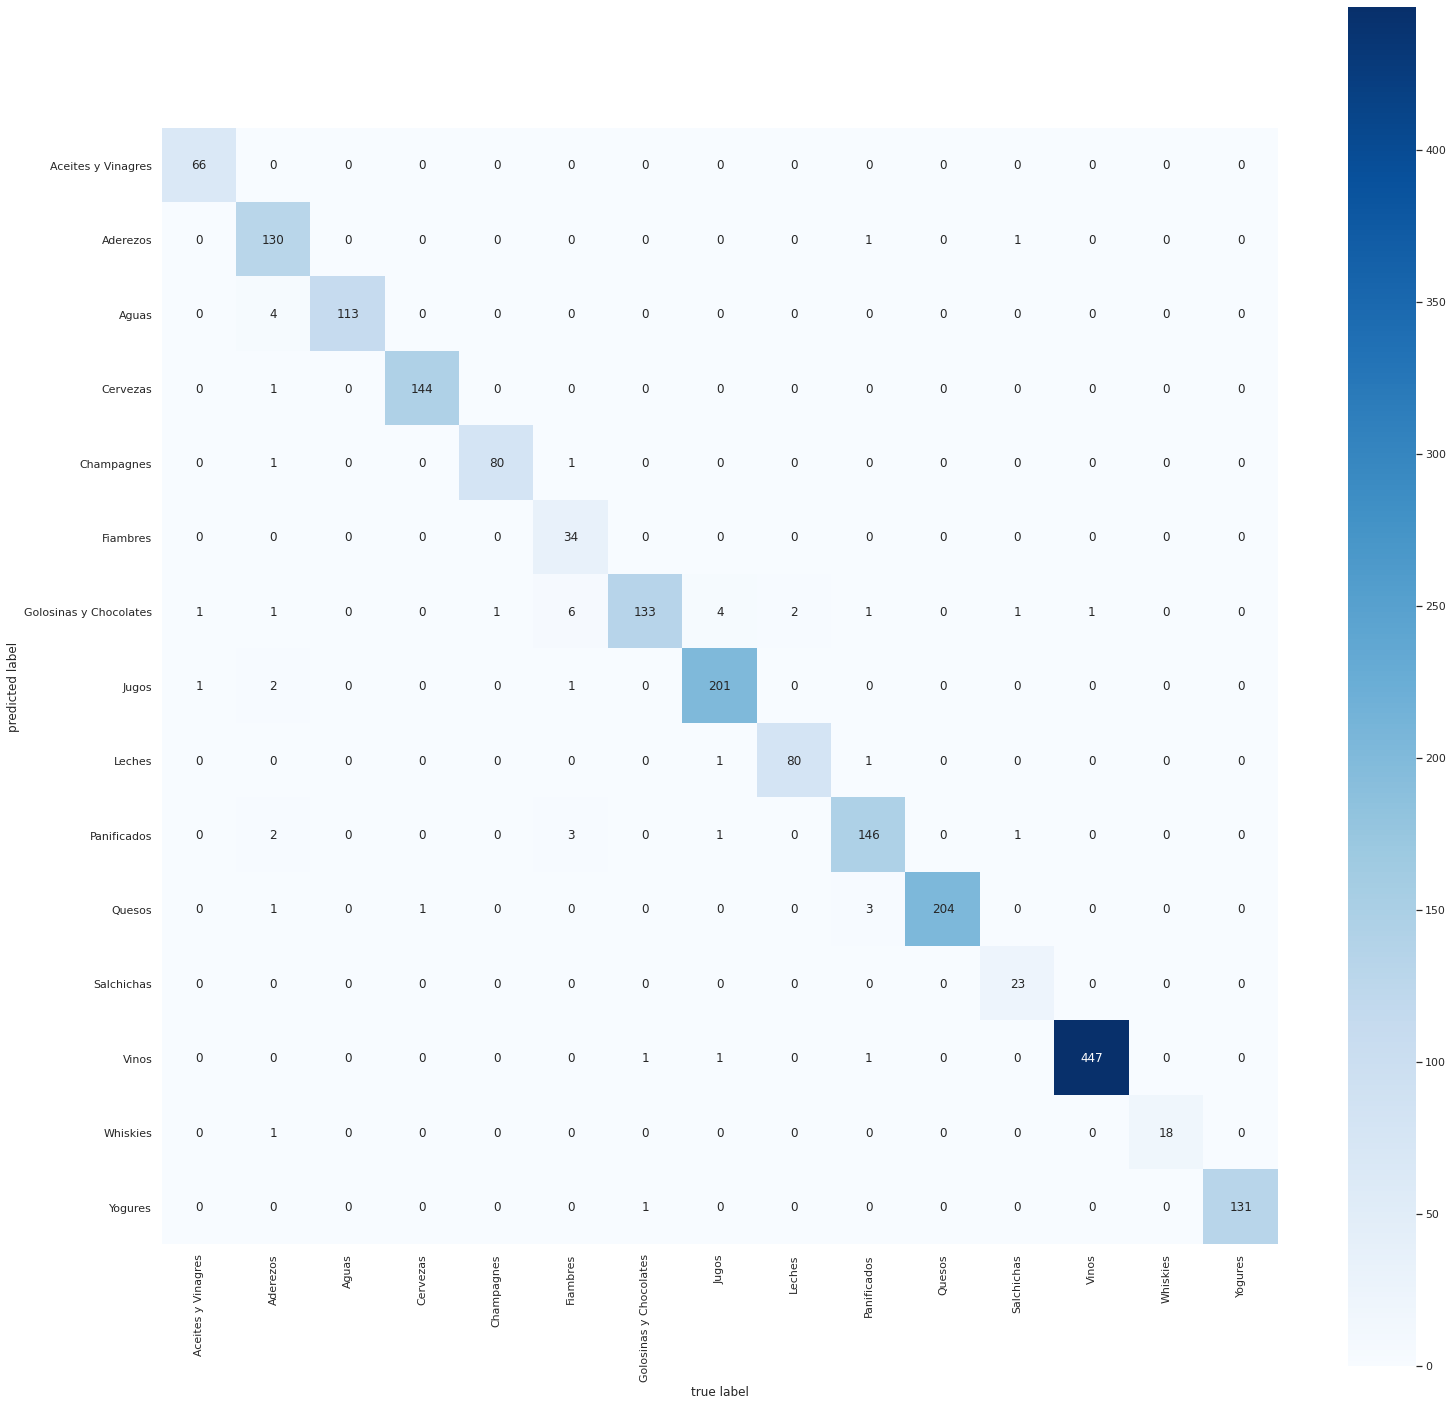

In [38]:
plt.figure(figsize=(25,25))
mat = confusion_matrix(Y_test, y_pred_text)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', 
            xticklabels=y.columns,
            yticklabels=y.columns)
plt.xlabel('true label')
plt.ylabel('predicted label')

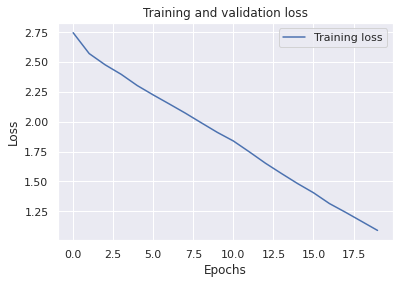

In [39]:
plt.plot(history.history['loss'], label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

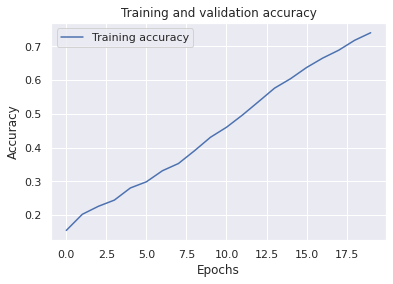

In [40]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predición de categorías en el dataset de pruebas (test_challenge.csv)


In [42]:
testing_df = pd.read_csv('test_challenge.csv')
testing_df['first_words']  = testing_df.name.str.split().str.get(0)
testing_df.head(5)

,name,description,maker,trademark,first_words
0,Queso Sancor Gouda 280 Gr,Queso Sancor Gouda 280 Gr,NaN,Sancor,Queso
1,Jugo De Limón Delemon 1 L,Jugo De Limón Delemon 1 L,NaN,Delemon,Jugo
2,Turrón Georgalos De Yema,Turrón Georgalos De Yema,NaN,Georgalos,Turrón
3,Ketchup Danica X220Gr.Dp,Ketchup Danica X220Gr.Dp,NaN,La Gallega,Ketchup
4,Queso Reggianito La Paulina Trozado Paquete 1 Kg,Queso Reggianito La Paulina Trozado Paquete 1 Kg,NaN,La Paulina,Queso


In [43]:

testing_df['words'] = testing_df['name'].apply(word_tokenize)
testing_df['words'] = testing_df['words'].apply(preproccesing)
testing_df['words'] = testing_df['words'].apply(lambda x: ' '.join(map(str, x)))
testing_df.head()

,name,description,maker,trademark,first_words,words
0,Queso Sancor Gouda 280 Gr,Queso Sancor Gouda 280 Gr,NaN,Sancor,Queso,queso sancor gouda 280 gr
1,Jugo De Limón Delemon 1 L,Jugo De Limón Delemon 1 L,NaN,Delemon,Jugo,jugo de limón delemon 1 l
2,Turrón Georgalos De Yema,Turrón Georgalos De Yema,NaN,Georgalos,Turrón,turrón georgalos de yema
3,Ketchup Danica X220Gr.Dp,Ketchup Danica X220Gr.Dp,NaN,La Gallega,Ketchup,ketchup danica x220grdp
4,Queso Reggianito La Paulina Trozado Paquete 1 Kg,Queso Reggianito La Paulina Trozado Paquete 1 Kg,NaN,La Paulina,Queso,queso reggianito la paulina trozado paquete 1 kg


In [44]:
x_testing = testing_df['words']
testing_df['category_id'] = best_model.predict(x_testing)

23/23 [==============================] - 0s 2ms/step


In [46]:
testing_df

,name,description,maker,trademark,first_words,words,category_id
0,Queso Sancor Gouda 280 Gr,Queso Sancor Gouda 280 Gr,NaN,Sancor,Queso,queso sancor gouda 280 gr,10
1,Jugo De Limón Delemon 1 L,Jugo De Limón Delemon 1 L,NaN,Delemon,Jugo,jugo de limón delemon 1 l,7
2,Turrón Georgalos De Yema,Turrón Georgalos De Yema,NaN,Georgalos,Turrón,turrón georgalos de yema,1
3,Ketchup Danica X220Gr.Dp,Ketchup Danica X220Gr.Dp,NaN,La Gallega,Ketchup,ketchup danica x220grdp,7
4,Queso Reggianito La Paulina Trozado Paquete 1 Kg,Queso Reggianito La Paulina Trozado Paquete 1 Kg,NaN,La Paulina,Queso,queso reggianito la paulina trozado paquete 1 kg,10
...,...,...,...,...,...,...,...
908,Prepizza Con Salvado 1 U,Prepizza Con Salvado 1 U,NaN,La Panaderia,Prepizza,prepizza con salvado 1 u,9
909,Cerveza Imperial Scout 500 Cc,Cerveza Imperial Scout 500 Cc,Imperial,Imperial,Cerveza,cerveza imperial scout 500 cc,3
910,Vino Tinto Humberto Canale Estate Pinot Noir 7...,Vino Tinto Humberto Canale Estate Pinot Noir 7...,NaN,Humberto Canale,Vino,vino tinto humberto canale estate pinot noir 7...,12
911,Leche Entera Vital 3 Nutriplus 200 mL,Leche Entera Vital 3 Nutriplus 200 mL,Danone Argentina,Vital,Leche,leche entera vital 3 nutriplus 200 ml,8


In [47]:
categories_index = pd.DataFrame(y.columns.values.tolist(), [y.columns.get_loc(c) for c in y.columns if c in y], columns = ['category'])

In [48]:
testing_df.join(categories_index,how = 'left', on = 'category_id')

,name,description,maker,trademark,first_words,words,category_id,category
0,Queso Sancor Gouda 280 Gr,Queso Sancor Gouda 280 Gr,NaN,Sancor,Queso,queso sancor gouda 280 gr,10,Quesos
1,Jugo De Limón Delemon 1 L,Jugo De Limón Delemon 1 L,NaN,Delemon,Jugo,jugo de limón delemon 1 l,7,Jugos
2,Turrón Georgalos De Yema,Turrón Georgalos De Yema,NaN,Georgalos,Turrón,turrón georgalos de yema,1,Aderezos
3,Ketchup Danica X220Gr.Dp,Ketchup Danica X220Gr.Dp,NaN,La Gallega,Ketchup,ketchup danica x220grdp,7,Jugos
4,Queso Reggianito La Paulina Trozado Paquete 1 Kg,Queso Reggianito La Paulina Trozado Paquete 1 Kg,NaN,La Paulina,Queso,queso reggianito la paulina trozado paquete 1 kg,10,Quesos
...,...,...,...,...,...,...,...,...
908,Prepizza Con Salvado 1 U,Prepizza Con Salvado 1 U,NaN,La Panaderia,Prepizza,prepizza con salvado 1 u,9,Panificados
909,Cerveza Imperial Scout 500 Cc,Cerveza Imperial Scout 500 Cc,Imperial,Imperial,Cerveza,cerveza imperial scout 500 cc,3,Cervezas
910,Vino Tinto Humberto Canale Estate Pinot Noir 7...,Vino Tinto Humberto Canale Estate Pinot Noir 7...,NaN,Humberto Canale,Vino,vino tinto humberto canale estate pinot noir 7...,12,Vinos
911,Leche Entera Vital 3 Nutriplus 200 mL,Leche Entera Vital 3 Nutriplus 200 mL,Danone Argentina,Vital,Leche,leche entera vital 3 nutriplus 200 ml,8,Leches


In [50]:
testing_predictions = testing_df.drop(['first_words','words','category_id'], axis =1)

In [51]:
testing_predictions.to_csv('predicciones_test_challenge.csv', sep = ";")

# Resumen de la aproximanción al problema  y conclusiones


Con la finalidad de cumplir con los objetivos del ejercicio, se consideró en primer lugar la estrategia "Zero Shot Classification"  a partir de un modelo pre-entrenado disponible en HuggingFace para realizar la clasificación semántica de  los nombres de los artítculos a una de las 15 sub-categorías predeterminadas de los productos.

Este modelo se aplicó unicamente a la primera palabra de cada producto por temas de rendimiento. La oportunidad de mejora en la clasificación de las categorías utilizando este modelo está en utilizar el nombre completo o la descripción completa como entrada del modelo. Lo cual podría tomar alrededor de 10 horas.

Esta estrategia da un buen resultado y eventualmente podría compararse con otras metodologías como guided-Lda o neural topic model.Para lo cual se requeriría mucho más trabajo en la comprensión de las categorías.

En la segunda parte del ejercicio se entrenó un clasificador mediante redes neuronales sencillas tipo perceptron multicapa, que son adecuadas para tareas de clasificación. Cabe mencionar que se realizó un modelo base para establecer si la estrategia tenía buenos resultados en el dataset de entrenamiento, el cual arrojo buenos resultados y  fue util para los valores que se ajustaron en el gridsearch. Luego, se procedió a entonar los hiperparámetros mediante gridsearch  y se logró un aumento consideranble en la precisión. Este aumento aunque notorio, es importante únicamente de acuerdo con el contexto del problema. 

Y por último es importante mencionar que se alcanzó un accuracy del 95% en el dataset de pruebas. Lo que muestra que la estrategia para la clasificación es efectiva. 







